# Lab session of 23/03/2022

## Graph problem 1: the shortest path problem

Find the shortest path connecting two nodes on a randomly generated graph with $k$ nodes, where two nodes are connected if their Euclidean distance is not more than $d_{\max}$. Specifically:

1. Generate $k$ points by creating random $x,y$ coordinates for each; the coordinates should be in the interval $[0,100]$;
2. Create edges by joining all node pairs whose distance is at most $d_{\max}$;
3. Create the optimization model for the shortest path problem, i.e., flow-based, based on the created graph; assume the path is from node 0 to node 12;
4. Solve the optimization model and determine the shortest path.

## Solution

We'll carry out each step one by one. In order to check our progress, we'll use the `matplotlib` Python module for visualizing what we obtained so far. We can also use `numpy` for generating a few random numbers. Here we create a $k\times 2$ multiarray that contains the $(x,y)$ coordinates of each of the $k$ points.

Point $i$ has coordinates `point[i]`. We compute the distance by any two points $i$ and $j$ and store all distances in a square $k\times k$ matrix we call `distance`. Note that `distance[i,i]` is always zero.

In [ ]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import math

k = 15
grid_size = 100  # size of the grid of points
d_max = .35 * grid_size

s = 0   # starting point
t = 12  # destination

np.random.seed(12345)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = np.random.random((k,2)) * grid_size # k*2 matrix
print(point)

[[92.96160928 31.63755546]
 [18.39188117 20.45602786]
 [56.77250291 59.5544703 ]
 [96.45145197 65.31770969]
 [74.89066375 65.35698709]
 [74.77148093 96.13067361]
 [ 0.83882979 10.64443767]
 [29.87037138 65.64111831]
 [80.98125525 87.21759137]
 [96.46475974 72.36853469]
 [64.24753279 71.74536208]
 [46.75990072 32.55846775]
 [43.96446059 72.96890827]
 [99.40145859 67.68737118]
 [79.08225178 17.09142578]]


Let's plot these points on the grid. We use `matplotlib` and specifically the function `matplotlib.pyplot`.

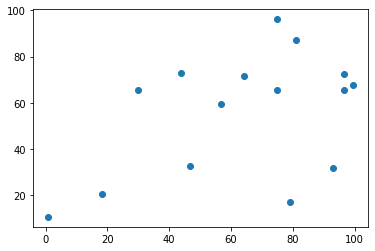

In [ ]:
import matplotlib.pyplot as plot
plot.scatter(point[:,0], point[:,1])
plot.show()

The `random` function call above uses a _random seed_ that is set on import. If we run the two cells above again, the coordinates would change and so would the graph. Anyone of us probably got a different set of points when running the above code.

Let's now determine all distances between each point. An explanation of this one-liner is provided at the end of this notebook.

In [ ]:
# Determine the distance between each point

V = [i for i in range(k)]
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

Now let's draw the graph we constructed: we need a new Python module called `networkx`, but then drawing the graph can be done in 7 lines of code.

To create a graph, we need a set $V$ of nodes, which we already have as it's the set of numbers from 0 to $k-1$. We also need a set of arcs $A$. For that we just take all tuples `(i,j)` such that the distance we computed above is not more than $d_{\max}$.

We then create a graph `g` as an object of the class `networkx.Graph`, we add the nodes from $V$ and the arcs from $A$. Then it's just a matter of calling `networkx.draw` by specifying the coordinates of the points. If the coordinates are not given, `networkx` can easily create them.

The coordinates are specified as a __dictionary__, one of the fundamental data types in Python: they can be specified as in the following example, with key-value pairs,

```python
phone_book = {
    'Alice': (555,3324),
    'Bob': (555,4620)
}
```

but we'll use a generator to create a dictionary that has nodes as keys and their coordinates $(x,y)$ as values. The `coord` object is only needed to draw the graph according to the right position of all nodes.

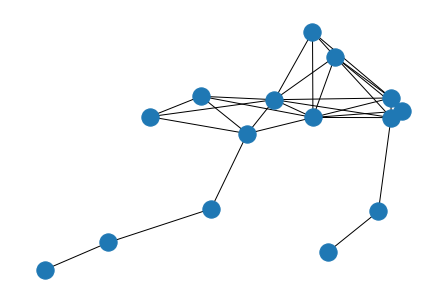

In [ ]:
import networkx as nx


# Set of arcs: note the condition that i!=j and especially the condition
# that prevents long arcs.
A = [ (i,j) for i in V for j in V if i!=j and distance[i,j] <= d_max ]

# Define a dictionary whose keys are the nodes, and the values are tuples
# containing the (x,y) coordinates of each point. Necessary for creating 
# a graph with networkx
coord = {i: (point[i,0], point[i,1]) for i in V} # Used to make graphs, it wants a dictionary

g = nx.Graph()

g.add_nodes_from(V)
g.add_edges_from(A)

nx.draw(g, pos=coord)

The input is done, now we need to create a MIP model after importing the `mip` module. The formulation is as follows (note that $d_{ij}$ is the distance between $i$ and $j$):

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in A} d_{ij} f_{ij}\\
   \textrm{s.t.} & \sum_{j \in V: (i,j) \in A} f_{ij} -  \sum_{j \in V: (j,i) \in A} f_{ji} = b_i & \forall i\in V\\
  & f_{ij} \ge 0 & \forall (i,j) \in A
\end{array}
$$

where $b_i = \left\{
   \begin{array}{ll}
      1 & \textrm{if }i=s\\
     -1 & \textrm{if }i=t\\
      0 & \textrm{otherwise}
   \end{array}
   \right.$. We start by importing `mip` and creating a model, then adding the two classes of variables $f$ and $x$ with appropriate index sets.

In [ ]:
# Create model and add variables
import mip

m = mip.Model()

f = { (i,j) : m.add_var() for (i,j) in A }

In [ ]:
# define b[i] for all i

b = { i: 0 for i in V }
b[s] = 1
b[t] = -1

# Write flow conservation constraint
for i in V:
  m.add_constr( mip.xsum( f[i,j] for j in V if (i,j) in A ) - mip.xsum( f[j,i] for j in V if (j,i) in A ) == b[i] )

Finally, the objective function: the sum over all arcs $(i,j)$ of their length $d_{ij}$ (i.e. the distance between nodes $i$ and $j$) multiplied by the variable $x_{ij}$.

In [ ]:
# Objective function
m.objective = mip.minimize(mip.xsum (distance[i,j] * f[i,j] for (i,j) in A ) )
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

If we didn't have any graphical tool, we could easily just print out the indices $(i,j)$ of the variables $x_{ij}$ that have a non-zero value:

In [ ]:
for (i,j) in A:
  if f[i,j].x > 0.01 : # We give it a treshold
    print( i, j )

0 3
3 10
10 12


But we'll use the `networkx.draw` function again and add some more features to visualize the tree on the graph. Note that `networkx.draw` can host multiple drawings of the same graph, and this can be useful to give a different width/color for the arcs that belong to the optimal solution as well as for showing where the root node is.

We put this code into a function as it will be called later when using the other formulation.

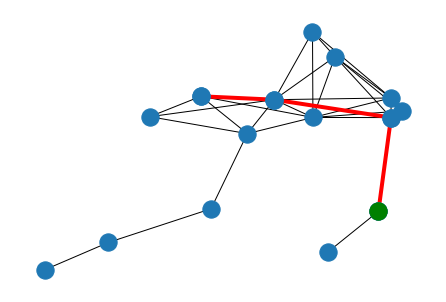

In [ ]:
def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord)

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable f[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if f[i,j].x > 0.001])
    nx.draw(g, pos=coord, width=4, edge_color='red')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='green')

    
# after defining the function, call it with the current data
draw_solution (V, A, f)

## Explanation of the definition of `distance`

In [ ]:
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

Let's analyze the above instruction given that it compresses quite a few operations on one line.

Consider the multiarray with the coordinates. Point 3, for example, has coordinates `point[3,0]` and `point[3,1]`. It can also be considered as a 2-vector with `point[3]`. 

In [ ]:
print(point[3,0])
print(point[3,1])
print(point[3])

Numpy can do operations on (sub-)vectors, so we can easily obtain the difference vector between point 2 and point 3, which will be obviously a 2-vector:

In [ ]:
print(point[2])
print(point[3])
print("vector difference:", point[3] - point[2])

For a numpy array `a`, the array `a**2` is such that every element is the square of each element of `a`.

In [ ]:
a = np.array([2,5])
print(a**2)

The `np.sum` operator obviously gives the sum of all elements in the vector, while `np.sqrt` takes the square root. 

In [ ]:
p1 = np.array([2,7])
p2 = np.array([5,3])

print('difference vector:', p1-p2)
print('squared difference:', (p1-p2)**2)
print('sum of the squared differences:', np.sum((p1-p2)**2))
print('its square root is:', np.sqrt(np.sum((p1-p2)**2)))

Now we just need to elaborate a bit on *list comprehensions*, i.e. how to create lists by looping over an index.

In [ ]:
table5 = np.array([[i*j for i in range(1,6)] for j in range(1,6)])
print(table5)

Well, this is the multiplication table from 1 to 5. The take-away message is that we have a nested list comprehension
```python
a = [[i*j for i in ...] for j in ...]
```
We can now read the instruction a little more easily:

In [ ]:
#                               squared difference between any two points 
#                                       ___________|___________
#                                      /                       \
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])
#                     \_________________________________________/
#                                            |
#                      square root of their sum (i.e. distance between i and j)
#                   \___________________________________________________________________/
#                                                        |
#                     List comprehension that computes the distance between any two points i and j

### Can we do it faster?

https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [ ]:
import numpy as np
import math

# Generate many random 2d points in [0, 100]
num_points = 1000
grid_size = 100
points = grid_size * np.random.random((num_points,2))

def slow_distance_matrix(points):
    return np.array([[math.sqrt(np.sum((pi - pj)**2)) for pi in points] for pj in points])

# TODO
def fast_distance_matrix(x):
    # Tip: do not use list comprehension, exploit numpy matrix operations
    return np.zeros((len(points), len(points)))

print("Running slow version")
%time m1 = slow_distance_matrix(points)

print("Running fast version")
%time m2 = fast_distance_matrix(points)

# Check if matrices contains the same values 
# (beware of floating point comparisons!!)
eps = 1e-5
assert (np.abs(m1 - m2) <= eps).all()